# MS030 Epoching
06/27/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re
import scipy

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS030'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Preprocessed Data

In [5]:
mne_data_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', preload=True)

photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

In [6]:
mne_data_reref

<Raw | wm_ref_ieeg.fif, 99 x 1252512 (2446.3 s), ~946.2 MB, data loaded>

In [7]:
photodiode_data

<Raw | photodiode.fif, 1 x 1252512 (2446.3 s), ~9.6 MB, data loaded>

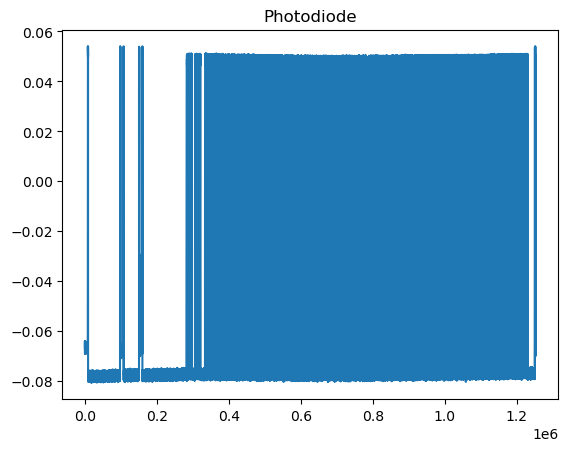

In [8]:
# Sanity check the photodiode
plt.plot(photodiode_data._data[0,])
plt.title("Photodiode")
plt.show()

### Load Anat Recon Info 


In [9]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination
0,LaCaS1,A32sg_L,-6.386112,38.974624,12.529659,-6.778861,29.725621,-10.464666,Gray,Left ACgG anterior cingulate gyrus,Area s32,L ACC,L CG,Left cingulate gyrus C,NaN
1,LaCaS2,A24rv_L,-6.386112,39.374364,17.322032,-6.875897,32.262463,-5.282710,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN
2,LaCaS3,A32sg_L,-6.386112,40.173843,22.513769,-6.814746,35.303751,0.166405,White,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN
3,LaCaS4,A32sg_L,-6.386112,40.573583,27.705506,-6.747162,37.927777,5.774297,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus E,NaN
4,LaCaS5,A32p_L,-6.785244,41.373063,32.497879,-7.088346,40.719284,10.822374,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,LsIPT6,A44v_L,-50.689779,19.387377,25.708684,-53.847567,16.199871,12.962351,White,Left OpIFG opercular part of the inferior fron...,Area 44,L IFG (p Opercularis),L IFG,Left pars opercularis B,WM
128,LsIPT7,A44v_L,-55.080232,20.586596,26.507413,-58.757549,17.231126,13.255615,Gray,Left OpIFG opercular part of the inferior fron...,Area 44,L IFG (p Opercularis),L IFG,Left pars opercularis B,NaN
129,LsIPT8,Unknown,-59.869818,22.985034,28.104871,-64.018796,19.634418,13.941256,Unknown,Unknown,Area 45,Unknown,Unknown,Unknown,OOB
130,uLAgIt,mAmyg_L,-19.557472,16.988938,-11.032842,-20.656646,-1.544513,-27.097992,Gray,Left Ent entorhinal area,Amygdala (LB),L ParaHippocampal Gyrus,L Amyg,Left amygdala inferior,NaN


## Load behavior

In [10]:
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
behav_df

,Round,Trial Num,TrialType,TrialOnset,ChoiceOnset,DecisionOnset,FeedbackOnset,RT,SafeBet,LowBet,...,weighted_low,p_g,p_s,util_rpe,util_tcpe,util_dcpe,util_tregret,util_dregret,util_trelief,util_drelief
0,1,71.0,gain,338.974325,338.990023,341.769751,343.785613,2.779728,0.4,0.00,...,0.000000,0.323013,0.676987,0.000000,0.000000,-0.138121,0.000000,0.000000,0.372833,-0.138121
1,2,45.0,mix,348.529057,348.538356,350.748341,352.764467,2.209985,0.0,-1.10,...,-0.613518,0.499058,0.500942,-0.612815,-1.226333,-0.613518,-1.226333,-0.613518,0.000000,0.000000
2,3,118.0,loss,357.472201,357.472927,361.825850,361.833741,4.352923,-0.3,-1.08,...,-0.605324,0.330469,0.669531,0.000000,-0.473530,-0.473530,-0.473530,-0.473530,0.000000,0.000000
3,4,38.0,mix,376.285557,376.286286,379.382670,381.399306,3.096384,0.0,-0.50,...,-0.344265,0.499471,0.500529,0.344265,0.000000,0.343870,0.000000,0.000000,0.688135,0.343870
4,5,135.0,loss,386.077311,386.087170,390.027117,392.043705,3.939948,-0.5,-1.24,...,-0.669816,0.525044,0.474956,0.669816,0.000000,0.688530,0.000000,0.000000,0.669816,0.688530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,88.0,gain,2034.227729,2034.228451,2036.572647,2038.588018,2.344195,0.5,0.00,...,0.000000,0.710376,0.289624,0.000000,0.000000,0.167474,0.000000,0.000000,0.769200,0.167474
146,147,116.0,loss,2043.926806,2043.932572,2047.849714,2049.865416,3.917142,-0.3,-0.84,...,-0.503506,0.459939,0.540061,0.000000,-0.503506,-0.029976,-0.503506,-0.029976,0.000000,0.000000
147,148,144.0,loss,2059.311537,2059.312296,2062.092662,2064.108756,2.780366,-0.6,-1.33,...,-0.705107,0.607895,0.392105,0.000000,-0.705107,0.081845,-0.705107,0.081845,0.000000,0.000000
148,149,128.0,loss,2069.315797,2069.316549,2073.719847,2075.736168,4.403297,-0.4,-1.44,...,-0.747387,0.294886,0.705114,0.000000,-0.747387,-0.162724,-0.747387,-0.162724,0.000000,0.000000


In [11]:
beh_ts = behav_df['TrialOnset']

## Photodiode alignment

In [12]:
# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            photodiode_data, 
                                            smoothSize=11, windSize=15, height=0.5)

11 blocks
...........

found matches for 120 of 165 pulses


## Make epochs

In [13]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}


In [14]:

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0],
       'DecisionOnset': [0, 3.0]}

In [15]:
epochs_all_evs = {f'{x}': np.nan for x in evs}
epochs_all_baseline = {f'{x}': np.nan for x in evs}

In [16]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/wm_ref_ieeg.fif', 
                 elec_path=anat_file, 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values, 
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1.0, 
                 downsamp_factor=2, IED_args=IED_args)

    epochs_all_evs[event] = ev_epochs


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 13606 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 14850 out of 14850 | elapsed:    3.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  99 out of  99 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 14326 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 14850 out of 14850 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 task

In [17]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 0.996094 sec, baseline off, ~87.2 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 3.99609 sec, baseline off, ~145.2 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add metadata to epochs

In [18]:
for event in evs.keys():

    # Let's add our behavioral events to the metadata. Substitute this with the particulars for your behavioral dataframe. 

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    event_metadata['safe'] = behav_df['SafeBet'].tolist()
    event_metadata['low'] = behav_df['LowBet'].tolist()
    event_metadata['high'] = behav_df['HighBet'].tolist()
    event_metadata['profit'] = behav_df['Profit'].tolist()
    event_metadata['outcome'] = behav_df['Outcome'].tolist()
    #model-free vars
    event_metadata['g_ev'] = behav_df['GambleEV'].tolist()
    event_metadata['cr'] = behav_df['CR'].tolist()
    event_metadata['c_ev'] = behav_df['choiceEV'].tolist()
    event_metadata['rpe'] = behav_df['RPE'].tolist()
    event_metadata['tcpe'] = behav_df['totalCPE'].tolist()
    event_metadata['dcpe'] = behav_df['decisionCPE'].tolist()
    event_metadata['tregret'] = behav_df['totalRegret'].tolist()
    event_metadata['dregret'] = behav_df['decisionRegret'].tolist()
    event_metadata['trelief'] = behav_df['totalRelief'].tolist()
    event_metadata['drelief'] = behav_df['decisionRelief'].tolist()
    event_metadata['util_g'] = behav_df['util_g'].tolist()
    event_metadata['util_s'] = behav_df['util_s'].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

In [19]:
epochs_all_evs[event].metadata

,lacas3,lacas11,lacas12,lmcms9,lmcms10,lcmmf3,lcmmf4,lcmmf6,lcmmf10,lcmmf15,...,c_ev,rpe,tcpe,dcpe,tregret,dregret,trelief,drelief,util_g,util_s
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.335,0.335,0.00,0.27,0.00,0.00,0.67,0.27,0.372833,0.510953
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.110,-1.210,-2.42,-1.10,-2.42,-1.10,0.00,0.00,-0.000704,0.000000
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,-0.30,-0.30,-0.30,-0.30,0.00,0.00,-0.605324,-0.473530
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.050,0.550,0.00,0.60,0.00,0.00,1.10,0.60,-0.000395,0.000000
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.620,0.620,0.00,0.50,0.00,0.00,1.24,0.50,-0.669816,-0.688530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.900,0.900,0.00,1.30,0.00,0.00,1.80,1.30,0.769200,0.601726
146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.420,-0.420,-0.84,-0.54,-0.84,-0.54,0.00,0.00,-0.503506,-0.473530
147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.665,-0.665,-1.33,-0.73,-1.33,-0.73,0.00,0.00,-0.705107,-0.786953
148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.720,-0.720,-1.44,-1.04,-1.44,-1.04,0.00,0.00,-0.747387,-0.584662


### Save epoched data

In [20]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/epoch_{event}.fif', overwrite=True)